In [1]:
# -*- coding: utf8 -*-


from sirsaia import brasilio
from sirsaia import epiestim
from sirsaia import plotutils


import glob
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import os
import pandas as pd
import pytz

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
plotutils.init_matplotlib()
plt.ion()
plt.style.use('tableau-colorblind10')
plt.rcParams['figure.figsize']  = (24, 16)

In [3]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
brazil = df_orig[df_orig['Country/Region'] == 'Brazil'].T
brazil = brazil[4:].copy()
brazil.index = pd.to_datetime(brazil.index)
brazil = brazil.sort_index().astype('i').diff().fillna(0)
first_day = np.nonzero(brazil.values)[0][0]
brazil = brazil.iloc[first_day:]
brazil.columns = ['local']


df_dead = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
brazil_dead = df_dead[df_dead['Country/Region'] == 'Brazil'].T
brazil_dead = brazil_dead[4:].copy()
brazil_dead.index = pd.to_datetime(brazil_dead.index)
brazil_dead = brazil_dead.sort_index().astype('i').diff().fillna(0)
first_day = np.nonzero(brazil_dead.values)[0][0]
brazil_dead = brazil_dead.iloc[first_day:]
brazil_dead.columns = ['deaths']

brazil = brazil.join(brazil_dead, how='outer').fillna(0)

In [4]:
def plot_site(df):
    plt.subplot(3, 1, 1)
    plotutils.plot_it(df)
    left, right = plt.xlim()
    plt.gca().yaxis.grid(True)
    plotutils.despine()

    plt.subplot(3, 1, 2)
    plotutils.plot_it(df, deaths=True)
    plt.xlim(left=left, right=right)
    plt.gca().yaxis.grid(True)
    plotutils.despine()

    #plt.subplot(3, 1, 3)
    #plotutils.plot_weekdiff(df)
    #plt.xlim(left=left, right=right)
    #plotutils.despine()

    plt.subplot(3, 1, 3)
    # if 'imported' in df.columns:
    #     cols = ['local']
    # else:
    cols = ['local']
    config = epiestim.make_config(mean_si=4.7, std_si=2.9)
    epiestim_result = epiestim.estimate_r(df[cols], config)
    plotutils.plot_result(epiestim_result, df)
    plt.ylim(0, 3)
    plt.xlim(left=left, right=right)
    plt.gca().yaxis.grid(True)

    plt.tight_layout(pad=2)
    return epiestim_result

epiestim_result = plot_site(brazil)
plt.savefig('plots/Brasil.png', dpi=72)
plt.close()

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


In [5]:
#model_df = brasilio.get_state(full_df, 'TO')
#epiestim_result = plot_site(model_df)

In [6]:
epiestim_result['t_start'] = brazil.index[(epiestim_result['t_start'] - 1).astype('i').values]
epiestim_result['t_end'] = brazil.index[(epiestim_result['t_end'] - 1).astype('i').values]
epiestim_result['country'] = 'Brazil'
epiestim_result['state'] = np.nan
epiestim_result['city'] = np.nan
epiestim_result.to_csv('results.csv', mode='w', header=True, index=False)

In [7]:
!rm caso.csv.gz*
!wget https://data.brasil.io/dataset/covid19/caso.csv.gz
full_df = pd.read_csv('caso.csv.gz')

--2020-12-01 09:54:36--  https://data.brasil.io/dataset/covid19/caso.csv.gz
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving data.brasil.io (data.brasil.io)... 2606:4700:20::681a:9af, 2606:4700:20::681a:8af, 2606:4700:20::ac43:472d, ...
Connecting to data.brasil.io (data.brasil.io)|2606:4700:20::681a:9af|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11247836 (11M) [application/gzip]
Saving to: ‘caso.csv.gz’

caso.csv.gz         100%[===================>]  10.73M  1.53MB/s    in 7.8s    

2020-12-01 09:54:45 (1.38 MB/s) - ‘caso.csv.gz’ saved [11247836/11247836]



In [8]:
regions = {'Centro-Oeste': ['DF', 'GO', 'MS', 'MT'],
          'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'], 
          'Norte': ['AC', 'AM', 'AP', 'PA', 'RO', 'RR', 'TO'],
          'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
          'Sul': ['PR', 'RS', 'SC']}

In [9]:
pop = pd.read_csv('data/populacao-estimada-2019.csv')

In [10]:
area = {
    'AM':1570.7,
    'PA':1247.6,
    'MT':903.3,
    'MG':587.5,
    'BA':564.6,
    'MS':357.1,
    'GO':340.0,
    'MA':332.0,
    'RS':281.7,
    'TO':277.6,
    'PI':251.5,
    'SP':248.2,
    'RO':237.5,
    'RR':224.2,
    'PR':199.3,
    'AC':152.5,
    'CE':148.8,
    'AP':142.8,
    'PE':98.3,
    'SC':95.3,
    'PB':56.4,
    'RN':52.8,
    'ES':46.0,
    'RJ':43.6,
    'AL':27.7,
    'SE':21.9,
    'DF':5.8}

In [11]:
x = []
y = []
z = []
names = []
for region in regions:
    for state in regions[region]:
        model_df = brasilio.get_state(full_df, state)
        dead = model_df['deaths'].iloc[-14:].mean()
        config = epiestim.make_config(mean_si=4.7, std_si=2.9)
        epiestim_result = epiestim.estimate_r(model_df[['local']], config)
        pop_state = pop[pop['uf'] == state]['populacao_estimada'].sum()
        z.append(pop_state)
        rt = epiestim_result['Mean(R)'].iloc[-14:].mean()
        
        x.append(rt)
        y.append(dead)
        names.append(state)

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


In [12]:
plt.scatter(x, y, s=np.array(z)/10000, lw=0, edgecolors='k', zorder=2, alpha=0.6)
ax = plt.gca()
ax.set_yscale('log')
plt.ylabel('Média de mortes nos últimos 14 dias. Escala log.')
plt.xlabel('R(t) médio nos últimos 14 dias')
plt.title('O tamanho de cada ponto é de acordo com a população do estado.')

for i, txt in enumerate(names):
    ax.annotate(txt, (x[i], y[i]), fontsize=16,
                verticalalignment='center',
                horizontalalignment='center')
    
plotutils.despine()
plt.tight_layout()
plt.savefig('plots/scatter.png', dpi=72)
plt.close()

In [13]:
mr = []
for region in regions:
    for state in regions[region]:
        print(state)
        model_df = brasilio.get_state(full_df, state)
        epiestim_result = plot_site(model_df)
        plt.savefig('plots/{}/{}.png'.format(region, state), dpi=72)
        plt.close()
        
        epiestim_result['t_start'] = model_df.index[(epiestim_result['t_start'] - 1).astype('i').values]
        epiestim_result['t_end'] = model_df.index[(epiestim_result['t_end'] - 1).astype('i').values]
        epiestim_result['country'] = 'Brazil'
        epiestim_result['state'] = state
        epiestim_result['city'] = np.nan
        epiestim_result.to_csv('results.csv', mode='a', header=False, index=False)
        
        mr.append({'state': state,
                   'low': epiestim_result.iloc[-1]['Quantile.0.025(R)'],
                   'mid': epiestim_result.iloc[-1]['Mean(R)'],
                   'high': epiestim_result.iloc[-1]['Quantile.0.975(R)']
                  })
        
        top_5 = pop[pop['uf'] == state].sort_values(by='populacao_estimada')[-5:]['municipio']
        for city in top_5.values:
            try:
                model_df = brasilio.get_city(full_df, state, city)
                epiestim_result = plot_site(model_df)
                plt.savefig('plots/{}/{}-{}.png'.format(region, state, city), dpi=72)
                plt.close()

                epiestim_result['t_start'] = model_df.index[(epiestim_result['t_start'] - 1).astype('i').values]
                epiestim_result['t_end'] = model_df.index[(epiestim_result['t_end'] - 1).astype('i').values]
                epiestim_result['country'] = 'Brazil'
                epiestim_result['state'] = state
                epiestim_result['city'] = city
                epiestim_result.to_csv('results.csv', mode='a', header=False)
            except:
                plt.close()

DF


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


GO


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

MS


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

MT


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

AL


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

BA


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

CE


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

MA


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

PB


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

PE


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

PI


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

RN


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

SE


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

AC


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

AM


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

AP


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

PA


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

RO


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

RR


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

TO


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

ES


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

MG


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

RJ


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

SP


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

PR


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

RS


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

SC


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

In [14]:
mr = pd.DataFrame(mr)
mr = mr.set_index('state')

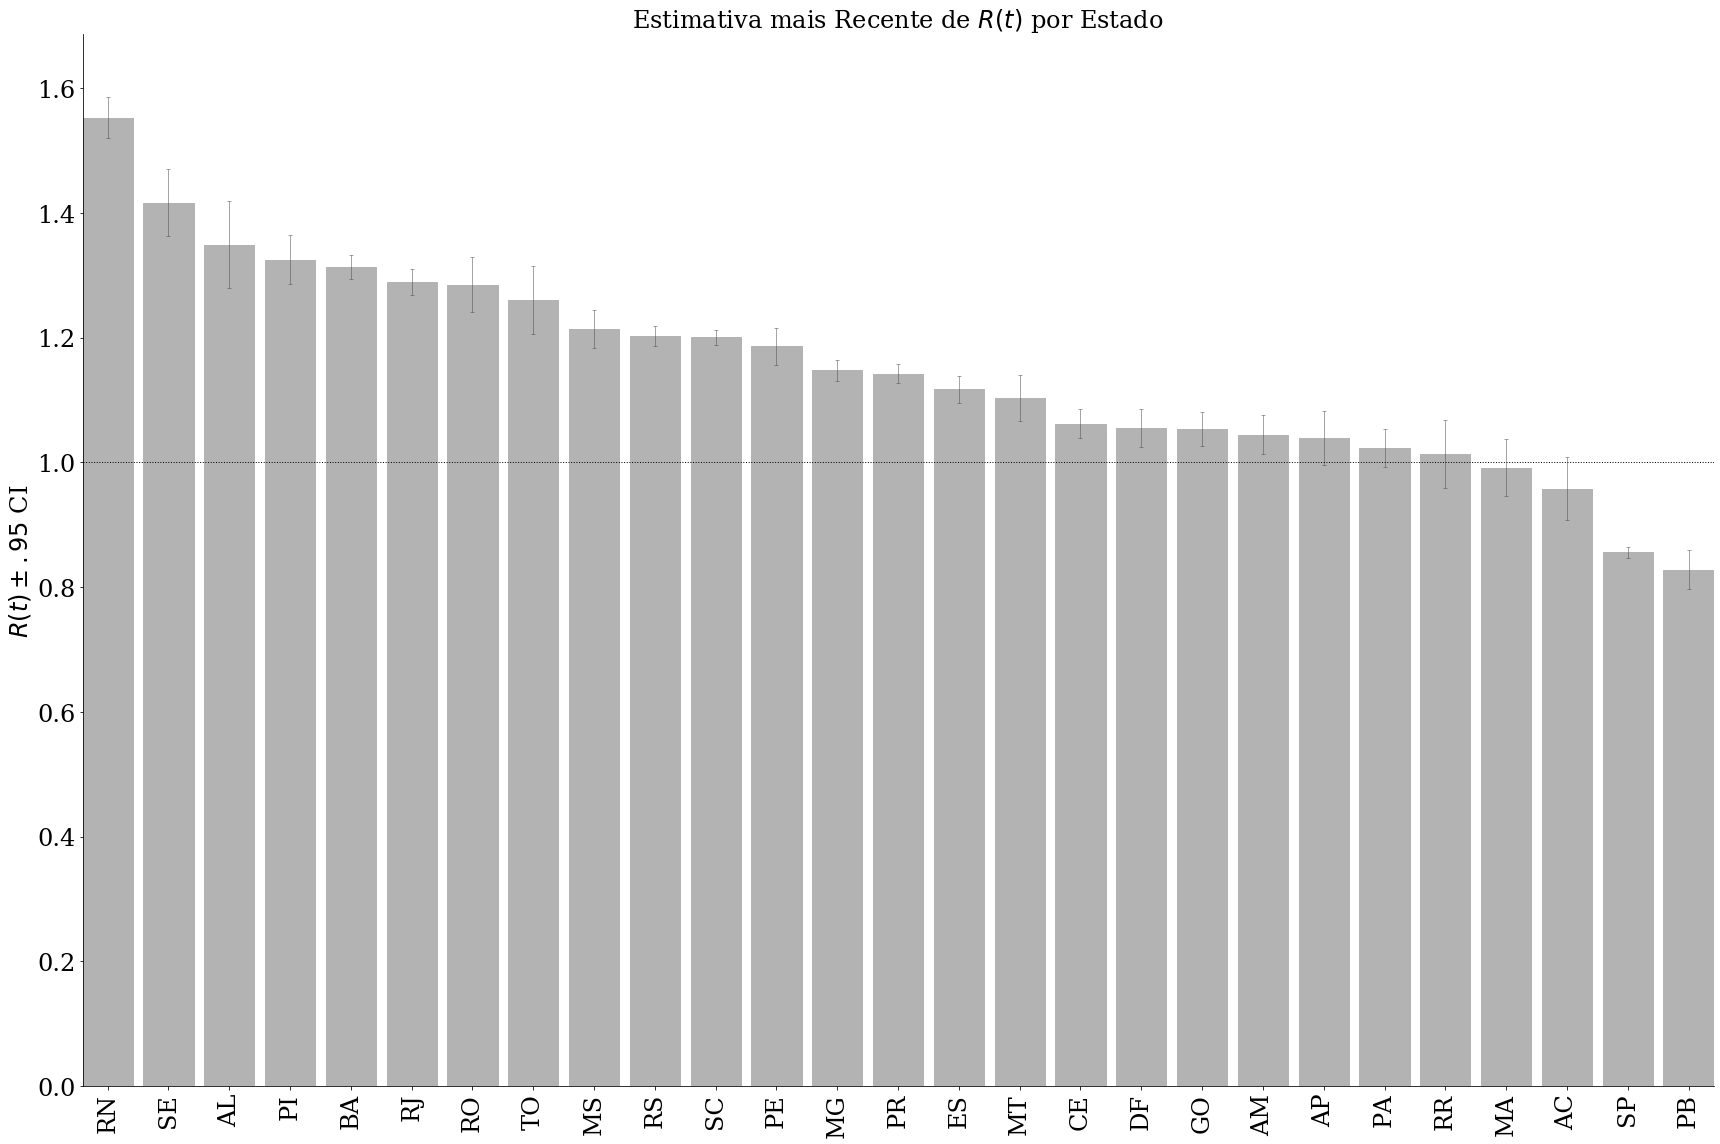

In [15]:
FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]


def plot_standings(mr, title='Estimativa mais Recente de $R(t)$ por Estado'):
    plt.title(title)
    err = mr[['low', 'high']].sub(mr['mid'], axis=0).abs()
    bars = plt.bar(mr.index,
                  mr['mid'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        bar.set_color([.7,.7,.7])
        
    labels = mr.index
    ax = plt.gca()
    ax.set_xticklabels(labels, rotation=90)
    ax.margins(0)
    ax.set_ylim(0, mr.high.max() + 0.1)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    plotutils.despine()
    plt.ylabel(r'$R(t) \pm .95$ CI')
    plt.tight_layout()
    plt.savefig('./plots/comparativo.png')
    
mr.sort_values('mid', inplace=True, ascending=False)
plot_standings(mr);

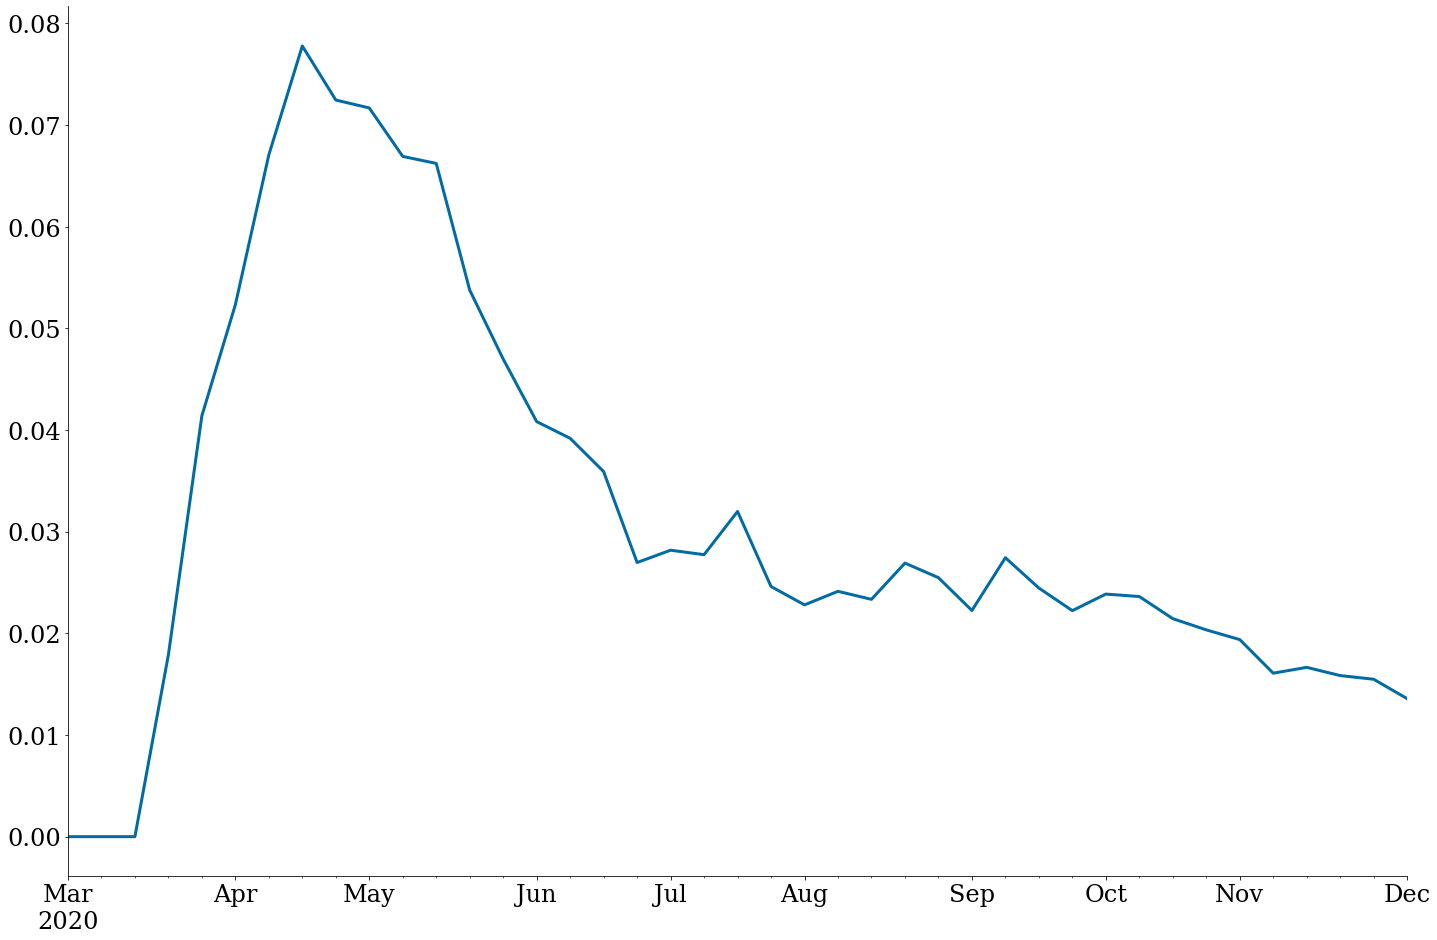

In [16]:
(brazil['deaths'] / brazil['local']).fillna(0).resample('1W').mean().plot()
plotutils.despine()

In [17]:
df_orig

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,44503,44706,44988,45280,45490,45716,45839,45966,46215,46498
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,32196,32761,33556,34300,34944,35600,36245,36790,37625,38182
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,73774,74862,75867,77000,78025,79110,80168,81212,82221,83199
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,6207,6256,6304,6351,6428,6534,6610,6610,6712,6745
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,14413,14493,14634,14742,14821,14920,15008,15087,15103,15139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,70254,71644,73196,75007,76727,78493,80429,81890,83585,85647
267,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
268,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2093,2099,2107,2114,2124,2137,2148,2160,2177,2191
269,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,17394,17424,17454,17466,17535,17553,17569,17589,17608,17647


In [18]:
set(df_dead['Country/Region'])

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo (Brazzaville)',
 'Congo (Kinshasa)',
 'Costa Rica',
 "Cote d'Ivoire",
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Denmark',
 'Diamond Princess',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',
 'Grenada',
 'Guatemala',
 'Guinea',
 'Guinea-Bissau',
 'Guyana',

In [19]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_orig = df_orig.T[4:].copy()
df_orig.index = pd.to_datetime(df_orig.index)
df_orig = df_orig.sort_index().astype('i').diff().fillna(0)
first_day = np.nonzero(df_orig.values)[0][0]
df_orig = df_orig.iloc[first_day:]
df_orig = df_orig.sum(axis=1)

df_dead = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_dead = df_dead.T[4:].copy()
df_dead.index = pd.to_datetime(df_dead.index)
df_dead = df_dead.sort_index().astype('i').diff().fillna(0)
first_day = np.nonzero(df_dead.values)[0][0]
df_dead = df_dead.iloc[first_day:]
df_dead = df_dead.sum(axis=1)

In [20]:
df_dead

2020-01-23        1.0
2020-01-24        8.0
2020-01-25       16.0
2020-01-26       14.0
2020-01-27       26.0
               ...   
2020-11-26    10739.0
2020-11-27    10617.0
2020-11-28     9746.0
2020-11-29     6907.0
2020-11-30     8670.0
Length: 313, dtype: float64

In [21]:
df_orig = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_orig[4:]

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,11/21/20,11/22/20,11/23/20,11/24/20,11/25/20,11/26/20,11/27/20,11/28/20,11/29/20,11/30/20
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,14413,14493,14634,14742,14821,14920,15008,15087,15103,15139
5,NaN,Antigua and Barbuda,17.060800,-61.796400,0,0,0,0,0,0,...,139,139,139,139,140,141,141,141,141,141
6,NaN,Argentina,-38.416100,-63.616700,0,0,0,0,0,0,...,1366182,1370366,1374631,1381795,1390388,1399431,1407277,1413375,1418807,1424533
7,NaN,Armenia,40.069100,45.038200,0,0,0,0,0,0,...,124839,126224,126709,127522,129085,130870,132346,133594,134768,135124
8,Australian Capital Territory,Australia,-35.473500,149.012400,0,0,0,0,0,0,...,115,115,115,115,115,116,117,117,117,117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,70254,71644,73196,75007,76727,78493,80429,81890,83585,85647
267,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
268,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2093,2099,2107,2114,2124,2137,2148,2160,2177,2191
269,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,17394,17424,17454,17466,17535,17553,17569,17589,17608,17647


In [22]:
(df_dead / df_orig).fillna(0).resample('1W').mean().plot()
plotutils.despine()

TypeError: unsupported operand type(s) for /: 'float' and 'str'